# Visualize benchmarking results

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

## Read results

In [3]:
### Null simulation ###
null_sim_hitrates = pd.read_csv('results/benchmark/null_sim_hitrates.tsv', sep='\t', index_col=0)
null_sim_pct_sig_cluster = pd.read_csv('results/benchmark/null_sim_pct_sig_cluster.tsv', sep='\t', index_col=0)
null_sim_hitrate_cluster_rep = pd.read_csv('results/benchmark/null_sim_rep_hitrate_cluster.tsv', sep='\t', index_col=0)
null_sim_hitrate_cluster_norep = pd.read_csv('results/benchmark/null_sim_norep_hitrate_cluster.tsv', sep='\t', index_col=0)

### Simulation with differences ###
difs_sim_hitrates = pd.read_csv('results/benchmark/difs_sim_hitrates.tsv', sep='\t', index_col=0)
difs_sim_pct_sig_cluster = pd.read_csv('results/benchmark/difs_sim_pct_sig_cluster.tsv', sep='\t', index_col=0)
difs_sim_hitrate_cluster_rep = pd.read_csv('results/benchmark/difs_sim_rep_hitrate_cluster.tsv', sep='\t', index_col=0)
difs_sim_hitrate_cluster_norep = pd.read_csv('results/benchmark/difs_sim_norep_hitrate_cluster.tsv', sep='\t', index_col=0)

### Benchmarking bootstrapping ###
benchmark_hit_rates = pd.read_csv('results/benchmark/benchmark_hitrates.tsv', sep='\t')
benchmark_stats = pd.read_csv('results/benchmark/benchmark_stats.tsv', sep='\t')
best_auroc = pd.read_csv('results/benchmark/benchmark_best_auroc.tsv', sep='\t')

## Plots

In [4]:
def join_xticks(fig, ax, label):
    """ Add horizontal bar to join x axis labels in heatmap """
    
    ticks = ax.xaxis.get_major_ticks()
    ticks = [tick for tick in ticks if tick.label1._text == label]
    
    # Convert from display -> converted coordinates
    trans_y = ax.transData
    trans_y_inv = trans_y.inverted()                                      
    tick_bboxes = [tick.tick1line.get_window_extent().transformed(trans_y_inv) for tick in ticks] 
    bbox_trans = tick_bboxes[0]
    
    #Plot horizontal line between ticks
    trans = transforms.blended_transform_factory(ax.transData, trans_y)
    tick_x = [tick._loc for tick in ticks]  # data coordinates
    tick_y = [bbox_trans.y0 + (bbox_trans.y0-bbox_trans.y1)/2]*2  #converted coordinates + half length
    ax.plot(tick_x, tick_y, color="black", lw=0.8, transform=trans, clip_on=False)

    # Move labels using transform
    dx = 0.1
    offset = transforms.ScaledTranslation(dx, 0, fig.dpi_scale_trans)
    ticks[0].label1.set_transform(ticks[0].label1.get_transform() + offset)
    _ = [tick.label1.set_visible(False) for tick in ticks[1:]]

### Hit rates

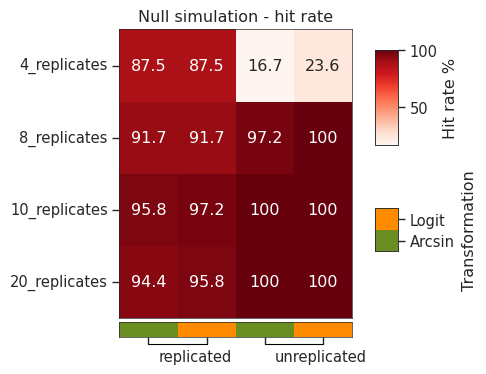

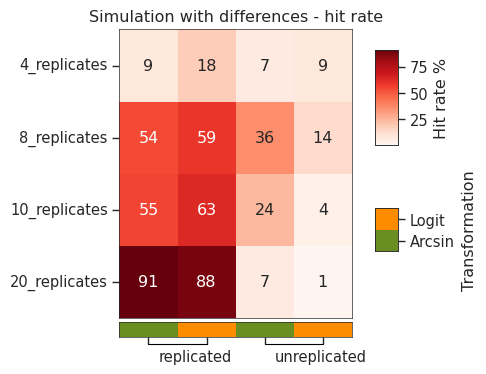

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as transforms
simulations = {'Null simulation': null_sim_hitrates,
               'Simulation with differences': difs_sim_hitrates}

for sim in simulations:
    # Prepare data
    data = simulations[sim].copy()
    data = data.reset_index()
    data['reps'] = data['index'].str.split('_').str[1] + '_replicates'
    data['method'] = data['index'].str.split('_').str[0]
    data.drop('index', axis=1, inplace=True)
    data = data.set_index('reps')
    data = data.pivot(columns=['method'])
    data.columns = data.columns.map('_'.join).str.strip('_')
    data = data.iloc[np.argsort([int(data.index.str.split('_')[i][0]) for i in range(len(data.index.str.split('_')))]),:]

    # Initialize plotting grid
    fig, axarr = plt.subplots(2,1, figsize=(3, 4.), height_ratios=[0.95,0.05])
    axarr = axarr.flatten()
    plt.subplots_adjust(wspace=0.15, hspace=0.03)

    ############### Colorbars ################

    #Create extra axes for colorbars
    transform_colors = ["olivedrab", "darkorange"]
    ax = axarr[0]

    transform_cax = inset_axes(ax,
                                 width="10%", height="15%",
                                 loc='lower left',
                                 bbox_to_anchor=(1.1, 0.23, 1, 1),
                                 bbox_transform=ax.transAxes, borderpad=0)
    transform_cax.set_frame_on(True)


    pvalue_cax = inset_axes(ax,
                            width="10%", height="33%",
                            loc='lower left',
                            bbox_to_anchor=(1.1, 0.6, 1, 1),
                            bbox_transform=ax.transAxes, borderpad=0)
    pvalue_cax.set_frame_on(True)


    # First row
    ax = axarr[0]
    sns.heatmap(data, 
                annot=True, fmt='0.3g',
                ax=ax, cmap='Reds', cbar_ax=pvalue_cax, xticklabels=False, 
                cbar_kws={'label': 'Hit rate %'})

    # Second row
    ax = axarr[1]
    sns.heatmap([[0,1,0,1]], ax=ax, cbar_ax=transform_cax, 
                yticklabels=False, 
                cmap=transform_colors)

    #Transformation to categorical
    colorbar = axarr[1].collections[0].colorbar
    colorbar.set_label("Transformation", labelpad=5)
    colorbar.set_ticks([0.25,0.75])
    colorbar.set_ticklabels(["Arcsin", "Logit"])

    #xticks
    ax.set_xticks(ax.get_xticks(), ["replicated",  "replicated", "unreplicated", "unreplicated"], 
                  rotation=0, ha='left', rotation_mode='default')
    join_xticks(fig, ax, "replicated")
    join_xticks(fig, ax, "unreplicated")


    ############ Final adjustments ##############

    #Titles
    axarr[0].set_title(f"{sim} - hit rate")
    #axarr[1].set_title("Propeller")
    #axarr[2].set_title("scCODA")

    ### Set format of labels
    for ax in axarr:
        ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0, ha='right', rotation_mode='anchor')
        ax.set_ylabel("")
        ax.set_xlabel("")

        # Drawing the frame
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)

    #Border around cbars
    for cax in [pvalue_cax, transform_cax]:
        for _, spine in cax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.5)


    # Save final figure
    plt.savefig(f"{FIG_PATH}/{sim}_heatmap.pdf", bbox_inches="tight")

### Correct assignment per cluster

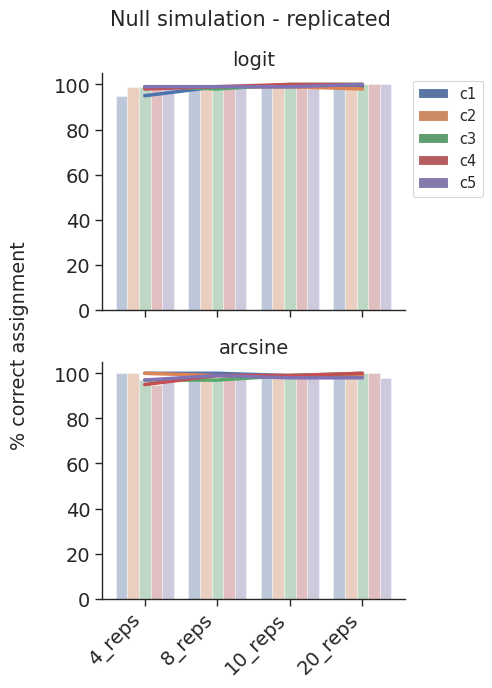

In [9]:
import warnings
warnings.filterwarnings("ignore")

# Prepare data
data = null_sim_hitrate_cluster_rep
data['trans'] = data['method'].str.split('_').str[0]
data['reps'] = data['method'].str.split('_', n=1).str[-1]

data_logit = data[data["trans"] == 'logit'].copy()
data_arcsin = data[data["trans"] == 'arcsin'].copy()

index_name = data_logit["reps"].unique()

# Prepare plot
fig, axarr = plt.subplots(2, sharex=True, sharey=True, height_ratios=[0.5,0.5],
                          figsize=(5, 7), tight_layout=True)
plt.subplots_adjust(hspace=0.5)
fig.supylabel('% correct assignment')
fig.suptitle('Null simulation - replicated', fontsize=15)

for ax in axarr:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
ax = axarr[0]

# Add title to plot
ax.set_title('logit', fontsize=14)


# Plot results of simulated run
sns.barplot(data=data_logit, x='reps', y='hit_rate', hue='cluster', alpha=0.4, ax=ax)
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]

# plot hit rate as lineplot
sns.lineplot(data=data_logit, x='reps', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='both', which='major', labelsize=14)

ax = axarr[1]
ax.set_title('arcsine', fontsize=14)

# Plot results of simulated run
sns.barplot(data=data_arcsin, x='reps', y='hit_rate', hue='cluster', alpha=0.4, ax=ax)
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]
ax.legend_.remove()

# plot hit rate as lineplot
sns.lineplot(data=data_arcsin, x='reps', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.tick_params(axis='both', which='major', labelsize=14)

# save
plt.savefig(f'{FIG_PATH}/null_simulation_rep_hitrate_clusters.pdf', dpi=300, bbox_inches='tight')

plt.show()

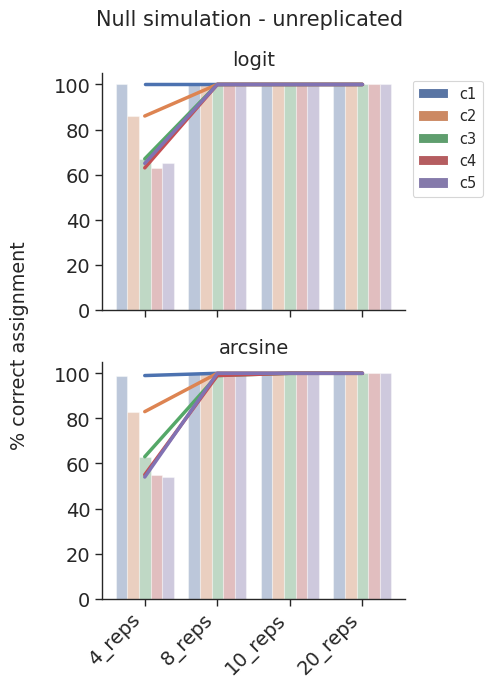

In [10]:
import warnings
warnings.filterwarnings("ignore")

# Prepare data
data = null_sim_hitrate_cluster_norep
data['trans'] = data['method'].str.split('_').str[0]
data['reps'] = data['method'].str.split('_', n=1).str[-1]

data_logit = data[data["trans"] == 'logit'].copy()
data_arcsin = data[data["trans"] == 'arcsin'].copy()

index_name = data_logit["reps"].unique()

# Prepare plot
fig, axarr = plt.subplots(2, sharex=True, sharey=True, height_ratios=[0.5,0.5],
                          figsize=(5, 7), tight_layout=True)
plt.subplots_adjust(hspace=0.5)
fig.supylabel('% correct assignment')
fig.suptitle('Null simulation - unreplicated', fontsize=15)

for ax in axarr:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
ax = axarr[0]

# Add title to plot
ax.set_title('logit', fontsize=14)

# Plot results of simulated run
sns.barplot(data=data_logit, x='reps', y='hit_rate', hue='cluster', alpha=0.4, ax=ax)
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]

# plot hit rate as lineplot
sns.lineplot(data=data_logit, x='reps', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='both', which='major', labelsize=14)

ax = axarr[1]
ax.set_title('arcsine', fontsize=14)

# Plot results of simulated run
sns.barplot(data=data_arcsin, x='reps', y='hit_rate', hue='cluster', alpha=0.4, ax=ax)
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]
ax.legend_.remove()

# plot hit rate as lineplot
sns.lineplot(data=data_arcsin, x='reps', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.tick_params(axis='both', which='major', labelsize=14)

# save
plt.savefig(f'{FIG_PATH}/null_simulation_norep_hitrate_clusters.pdf', dpi=300, bbox_inches='tight')

plt.show()

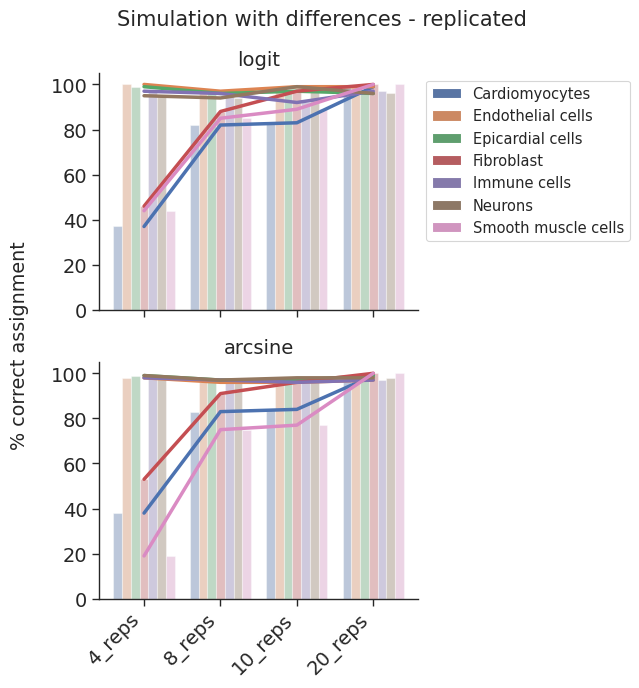

In [11]:
import warnings
warnings.filterwarnings("ignore")

# Prepare data
data = difs_sim_hitrate_cluster_rep
data['trans'] = data['method'].str.split('_').str[0]
data['reps'] = data['method'].str.split('_', n=1).str[-1]

data_logit = data[data["trans"] == 'logit'].copy()
data_arcsin = data[data["trans"] == 'arcsin'].copy()

index_name = data_logit["reps"].unique()

# Prepare plot
fig, axarr = plt.subplots(2, sharex=True, sharey=True, height_ratios=[0.5,0.5],
                          figsize=(6.5, 7), tight_layout=True)
plt.subplots_adjust(hspace=0.5)
fig.supylabel('% correct assignment')
fig.suptitle('Simulation with differences - replicated', fontsize=15)

for ax in axarr:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
ax = axarr[0]

# Add title to plot
ax.set_title('logit', fontsize=14)

# Plot results of simulated run
sns.barplot(data=data_logit, x='reps', y='hit_rate', hue='cluster', alpha=0.4, ax=ax)
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]

# plot hit rate as lineplot
sns.lineplot(data=data_logit, x='reps', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='both', which='major', labelsize=14)

ax = axarr[1]
ax.set_title('arcsine', fontsize=14)

# Plot results of simulated run
sns.barplot(data=data_arcsin, x='reps', y='hit_rate', hue='cluster', alpha=0.4, ax=ax)
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]
ax.legend_.remove()

# plot hit rate as lineplot
sns.lineplot(data=data_arcsin, x='reps', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.tick_params(axis='both', which='major', labelsize=14)

# save
plt.savefig(f'{FIG_PATH}/difs_simulation_rep_hitrate_clusters.pdf', dpi=300, bbox_inches='tight')

plt.show()

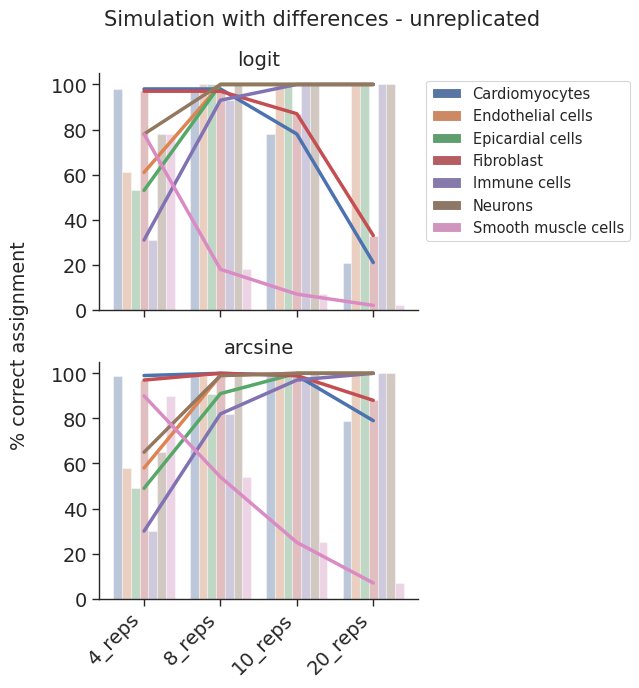

In [12]:
import warnings
warnings.filterwarnings("ignore")

# Prepare data
data = difs_sim_hitrate_cluster_norep
data['trans'] = data['method'].str.split('_').str[0]
data['reps'] = data['method'].str.split('_', n=1).str[-1]

data_logit = data[data["trans"] == 'logit'].copy()
data_arcsin = data[data["trans"] == 'arcsin'].copy()

index_name = data_logit["reps"].unique()

# Prepare plot
fig, axarr = plt.subplots(2, sharex=True, sharey=True, height_ratios=[0.5,0.5],
                          figsize=(6.5, 7), tight_layout=True)
plt.subplots_adjust(hspace=0.5)
fig.supylabel('% correct assignment')
fig.suptitle('Simulation with differences - unreplicated', fontsize=15)

for ax in axarr:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
ax = axarr[0]

# Add title to plot
ax.set_title('logit', fontsize=14)

# Plot results of simulated run
sns.barplot(data=data_logit, x='reps', y='hit_rate', hue='cluster', alpha=0.4, ax=ax)
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]

# plot hit rate as lineplot
sns.lineplot(data=data_logit, x='reps', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='both', which='major', labelsize=14)

ax = axarr[1]
ax.set_title('arcsine', fontsize=14)

# Plot results of simulated run
sns.barplot(data=data_arcsin, x='reps', y='hit_rate', hue='cluster', alpha=0.4, ax=ax)
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]
ax.legend_.remove()

# plot hit rate as lineplot
sns.lineplot(data=data_arcsin, x='reps', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.tick_params(axis='both', which='major', labelsize=14)

# save
plt.savefig(f'{FIG_PATH}/difs_simulation_norep_hitrate_clusters.pdf', dpi=300, bbox_inches='tight')

plt.show()

## Benchmarking bootstrapping

### sensitivity vs false positive rate

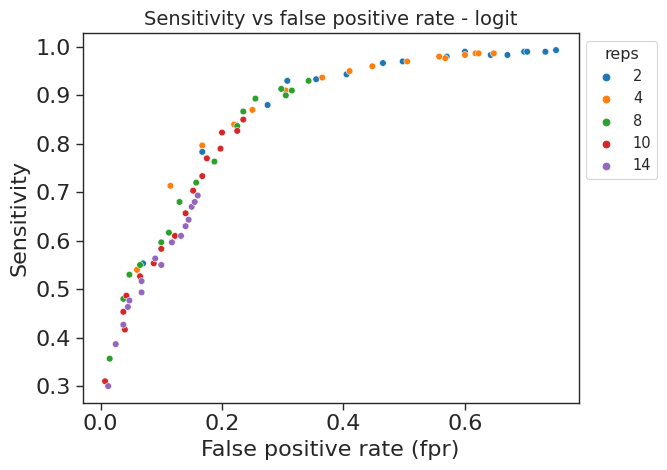

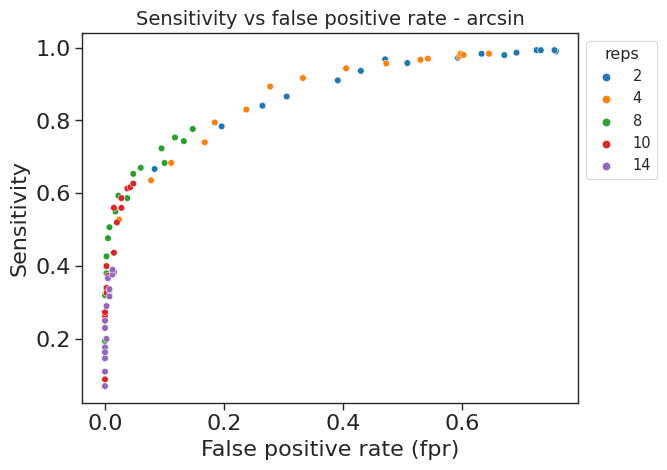

In [13]:
benchmark_stats_logit = benchmark_stats[benchmark_stats['trans'] == 'logit']
benchmark_stats_arcsin = benchmark_stats[benchmark_stats['trans'] == 'arcsin']

stats_data = {'logit': benchmark_stats_logit, 'arcsin': benchmark_stats_arcsin}

for trans in stats_data:

    ax = sns.scatterplot(data=stats_data[trans], x='fpr', y='sensitivity', hue='reps', palette='tab10')

    ax.set_ylabel('Sensitivity', fontsize=16)
    ax.set_xlabel('False positive rate (fpr)', fontsize=16)
    ax.set_title(f"Sensitivity vs false positive rate - {trans}", fontsize=14)

    plt.tick_params(axis='both', which='major', labelsize=16)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    plt.savefig(f'{FIG_PATH}/benchmark_sensitivity_fpr_{trans}.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()

### Mean counts vs auroc

In [14]:
# read best auroc per mean count data
best_auroc = pd.read_csv('results/benchmark/benchmark_best_auroc.tsv', sep='\t')
# extract number of reps with best auroc per mean counts
best_reps = best_auroc.drop_duplicates(['reps'], keep='last')['mean_counts'].to_list()
n_reps = best_auroc.drop_duplicates(['reps'], keep='last')['reps'].to_list()

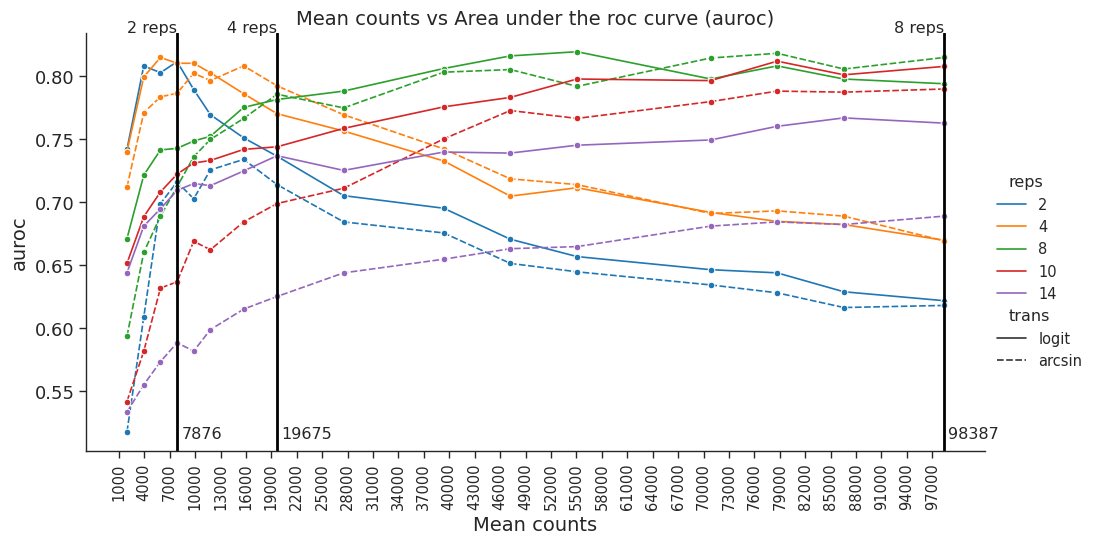

In [20]:
ticks = np.arange(1000, 100000, 3000)
x_labels = [str(label) for label in ticks]

plot_3 = sns.relplot(data=benchmark_stats, x='mean_counts', y='auroc', kind='line', errorbar=None,
                     hue='reps', aspect=2, marker='o', palette='tab10', style='trans')

for ax in plot_3.axes.flatten():
    ax.set_xticks(ticks, x_labels, rotation=90, ha='center')
    ax.set(xlabel='Mean counts', ylabel='auroc')

ax.set_ylabel('auroc', fontsize=14)
ax.set_xlabel('Mean counts', fontsize=14)

ax.set_title("Mean counts vs Area under the roc curve (auroc)", fontsize=14)

plt.tick_params(axis='y', which='major', labelsize=13)

# plot ranges of best number of replicates
for i in range(len(best_reps)):
    ax.axvline(best_reps[i], color='black', linewidth=2)
    ax.text(best_reps[i], ax.get_ylim()[1], f'{n_reps[i]} reps', ha='right')
    ax.text(best_reps[i]+500, ax.get_ylim()[0]+0.01, f'{int(best_reps[i])}', ha='left')
    
    
plt.savefig(f'{FIG_PATH}/benchmark_mean_counts_auroc.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# get results files path
result_files = glob.glob("results/benchmark/raw/*")

base = [os.path.splitext(os.path.basename(f))[0] for f in result_files]
methods = set([a.split("_", 3)[3] for a in base])

In [17]:
data = {method: {"rep": pd.read_csv(f'results/benchmark/raw/difs_sim_rep_{method}.tsv', sep="\t"),
                "norep": pd.read_csv(f'results/benchmark/raw/difs_sim_norep_{method}.tsv', sep="\t")} for method in methods}

mean_props = {method: data[method]['rep'].reset_index().groupby('clusters').mean()['baseline_props'].to_list() for method in methods}

plot_titles = {method: method for method in methods}

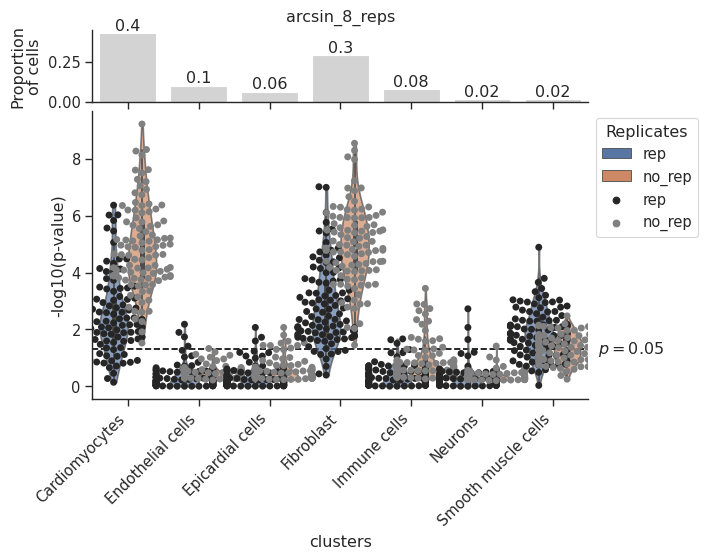

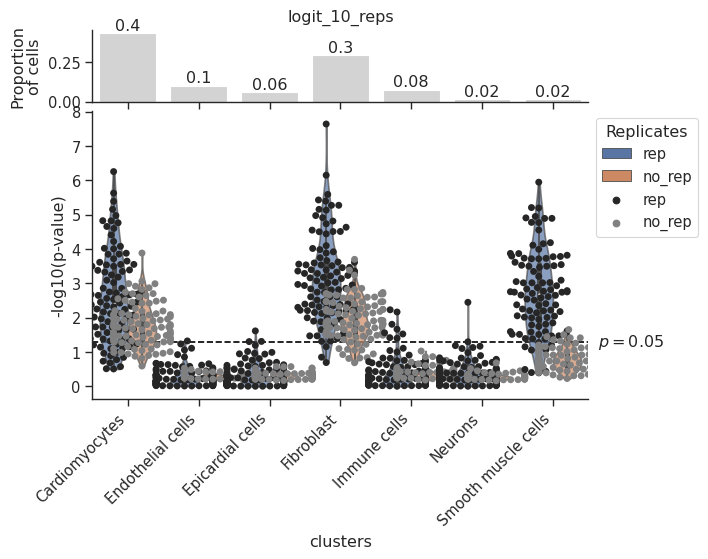

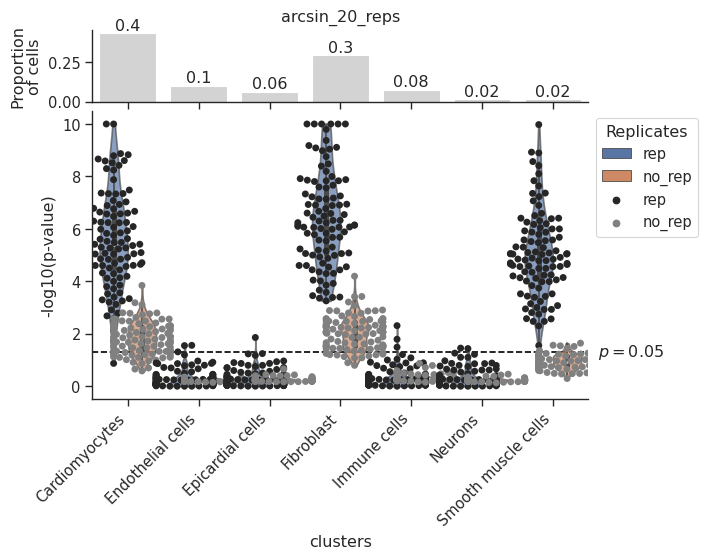

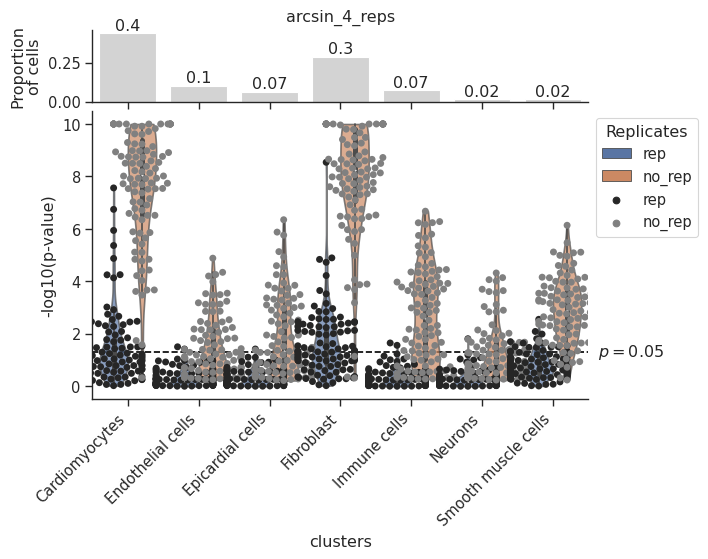

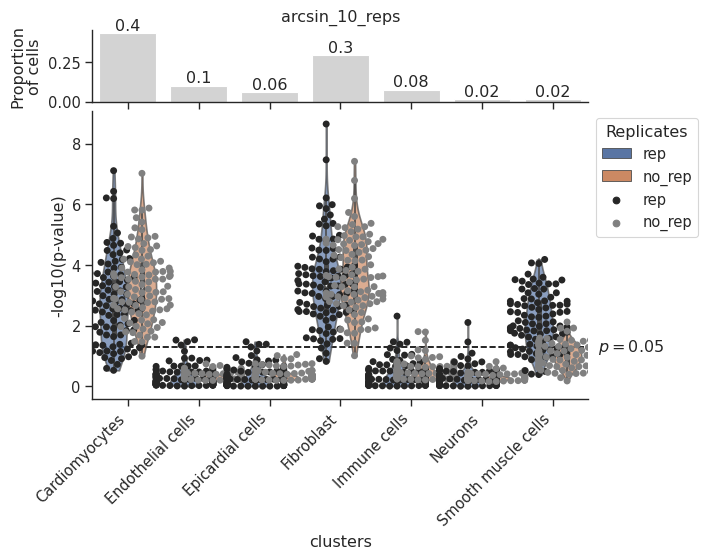

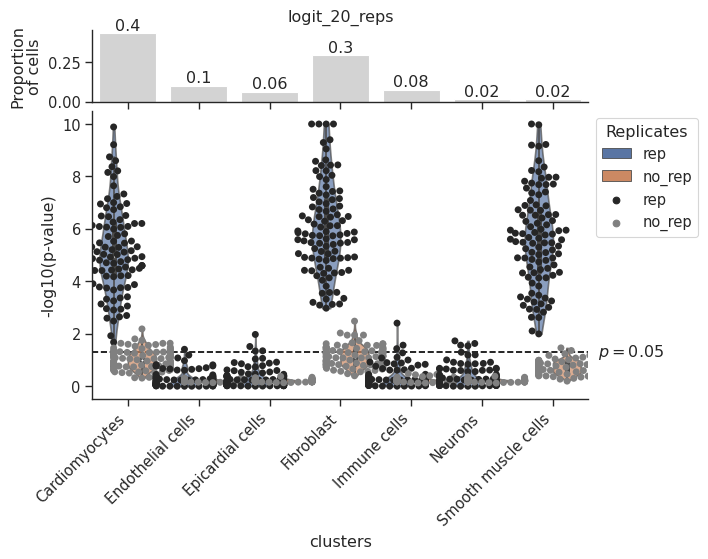

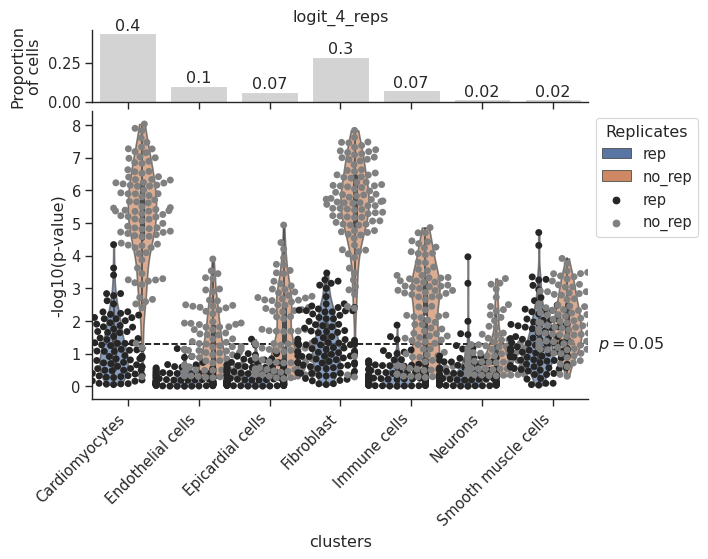

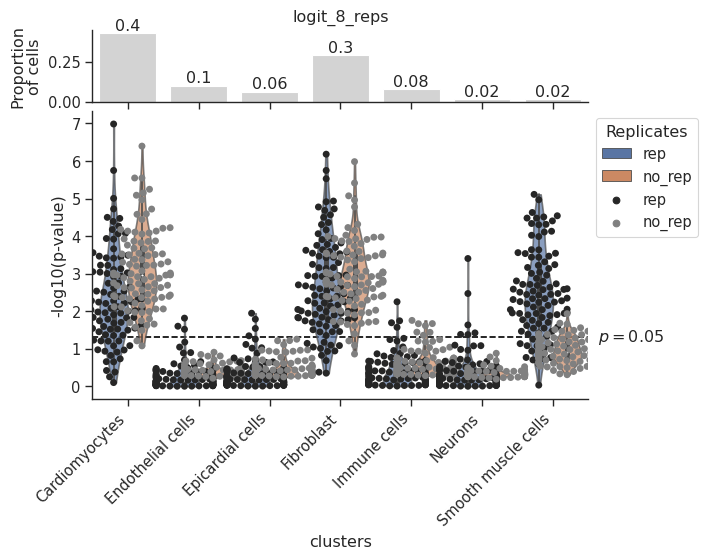

In [18]:
import warnings
warnings.filterwarnings("ignore")

for dataset in data:
    
    # Prepare data
    data_norep = data[dataset]["norep"].copy()
    data_rep = data[dataset]["rep"].copy()
    # replace very small p-values
    data_norep.iloc[:, -1] = np.where(data_norep.iloc[:, -1] < 10**-10, 10**-10, data_norep.iloc[:, -1])
    data_rep.iloc[:, -1] = np.where(data_rep.iloc[:, -1] < 10**-10, 10**-10, data_rep.iloc[:, -1])
    # convert to log(p-values)
    data_norep["-log10(p-value)"] = -np.log10(data_norep.iloc[:,-1])
    data_rep["-log10(p-value)"] = -np.log10(data_rep.iloc[:,-1])
    
    data_norep["Replicates"] = "no_rep"
    data_rep["Replicates"] = "rep"
    
    data_all = pd.concat([data_rep, data_norep])
    
    index_name = data_all["clusters"].unique()
    data_norep.reset_index(inplace=True)
    data_rep.reset_index(inplace=True)

    # Prepare plot
    fig, axarr = plt.subplots(2, sharex=True, height_ratios=[0.2,0.8])
    plt.subplots_adjust(hspace=0.05)
    
    for ax in axarr:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    ax = axarr[0]
    
    # Add title to plot
    ax.set_title(plot_titles.get(dataset, ""))

    # Add proportion on top
    ax = axarr[0]
    sns.barplot(x=index_name, y=mean_props[dataset], ax=ax, color="lightgrey")
    ax.set_xlabel("")
    ax.set_ylabel("Proportion\nof cells")
    ax.bar_label(ax.containers[0], fmt='%.g')

    # Plot results of simulated run
    ax = axarr[1]
    sns.violinplot(data_all, x="clusters", y="-log10(p-value)", 
                    cut=0, scale="width", ax=ax, hue="Replicates")
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
    # Remove duplicates entries in legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-2:], labels[-2:], loc="upper left", bbox_to_anchor=(1.05,1))
    
    sns.swarmplot(data_all, x="clusters", y="-log10(p-value)", color="grey", ax=ax,
                  hue="Replicates", dodge=True)
    
    # Plot threshold line
    pvalue_threshold = -np.log10(0.05)
    ax.axhline(pvalue_threshold, zorder=0, color="black", ls="--")
    ax.text(ax.get_xlim()[1], pvalue_threshold, "  $\it{p=0.05}$", va="center")
    
    # Set xticklabels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    plt.savefig(f"plots/{dataset}_bootstrap_comparison.pdf", dpi=300, bbox_inches="tight")
    plt.show()